# Lab 1 - Analysis of an EEG recording
## Advanced Biosignal Analysis
**Group 1: Octavi Font, Keith Kennedy, Fabio Stefanizzi**

_7 / 02 / 2018_


### Introduction
In this first lab of advanced biosignal analysis, we're performing an exploratory analysis on an EEG recording. For this task, the known priors are few. Most of the information we have is that the samples are retrieved from a hospital in the EU and are from an epilepsy patient that suffered a seizure. We were not given the sampling rate and we don't know the conditions concerning how the measuring was performed.

In [1]:
# Perform all the necessary imports to run the notebook
import numpy as np
from scipy.io import loadmat
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
sb.set()
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display

### Initial exploration of the data

We load our EEG recording into memory and convert it into a dataframe, which allows us to integrate the channel name with the samples and also slice and perform aggregate calculations on the data.

Even before visualizing the data, the channel names of the recording suggest that the physicians already had a good idea about where the seizures originated. All electrodes are placed on the left hemisphere, especially in the frontal and temporal lobes, so we suspect we'll encounter a rather localized seizure that the doctors should be able to pin down more accurately thanks to this test.

In [2]:
# Load the channel data and channel names into a dataframe
data = loadmat("EEG2.mat")
channels = [e[0][0] for e in data["channelNameArray"]]
df = pd.DataFrame(data["EEG"], columns=channels)
df.head()

TPL_1      TPL_2      TPL_3      TPL_4      TPL_5      TPL_6  \
0 -27.551406 -34.462840 -38.812855 -56.719830 -67.090027  -7.865168   
1 -30.863144 -39.550102 -41.786210 -60.314215 -73.468338 -10.354020   
2 -31.924660 -43.738717 -44.526194 -61.108000 -80.108301 -12.051408   
3 -29.384977 -44.372206 -46.127297 -59.461192 -86.926413 -11.328412   
4 -25.552154 -41.203828 -46.992636 -57.543648 -94.953539  -8.360914   

      TBAL_1     TBAL_2     TBAL_3     TBAL_4    ...         HSR_3      HSR_4  \
0 -34.049777  -4.099848 -46.680172  23.630162    ...    -49.280378 -64.149154   
1 -37.069845  -7.865896 -57.195700  26.798705    ...    -52.601297 -66.954135   
2 -40.103481 -10.014191 -63.115289  32.008616    ...    -55.158101 -68.795436   
3 -41.211321  -8.955009 -62.529991  42.819574    ...    -56.255670 -68.647583   
4 -39.679554  -6.161063 -57.179781  58.829911    ...    -56.397135 -66.814662   

       HSR_5      HSR_6     TBPR_1      TBPR_2     TBPR_3      TBPR_4  \
0 -31.226147 -45.332951 -35.340474 -147.136056 -15.239811  -60.595463   
1 -33.528312 -46.841330 -38.742695 -159.664277 -13.604505  -75.080643   
2 -35.388959 -47.671351 -42.440548 -173.676153  -9.119063  -88.286102   
3 -35.570811 -46.928014 -44.484498 -186.866225  -3.147619  -98.235751   
4 -33.811779 -44.774548 -43.896928 -196.054831  -0.070625 -106.459691   

      TBPR_5    TBPR_6  
0  14.716269  4.797958  
1   9.015847 -0.409172  
2   2.998466 -4.157667  
3  -2.661463 -5.450366  
4  -7.274367 -4.953632  

[5 rows x 59 columns]

Once the data is loaded, we create a function to plot it. We've conveniently expanded the function so that we can filter the plot by channel and timestep.

From the initial view, we can appreciate a seizure starting around the 700Kth sample which lasts until about the 1.1Mth sample. This seizure is focused on the left temporal lobe of the patient (see readings on the *TEL\** electrodes). Once the seizure ends, the brain still shows abnormal behaviour, still centered around the temporal lobe. The electrodes placed on the left frontal node are barely affected during the whole recording.

In [3]:
def plot_eeg(timesteps=None, channels=None, sampling_rate=None, title=""):
    if not timesteps:
        timesteps = (0, len(df))
    if not channels:
        channels = (0, len(df.columns))
    df_chopped = df[df.columns[channels[0] : channels[1]]][timesteps[0] : timesteps[1]]
    df_offseted = df_chopped.copy()
    df_range = np.average(df_chopped.std())*4*2  # separate signals 4 stds apart
    voltage_offset = np.arange(0,len(df_chopped.columns)*df_range, df_range)
    for i,c in enumerate(df_chopped.columns):
        df_offseted[c] += voltage_offset[i]
    ax = df_offseted.plot(legend=False, figsize=(17,9))
    ax.set_yticks(voltage_offset)
    ax.set_yticklabels(df_chopped.columns)
    if sampling_rate:
        xticks = np.linspace(timesteps[0], timesteps[1], 10)
        xticklabels = ['%.2f' % (f,) for f in np.linspace(timesteps[0]/sampling_rate, timesteps[1]/sampling_rate, 10)]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.set_xlabel("t (s)")
    else:
        ax.set_xlabel("t (a.u.)")
    ax.set_title(title)
    ax.set_ylabel("channels")
    plt.show()
    

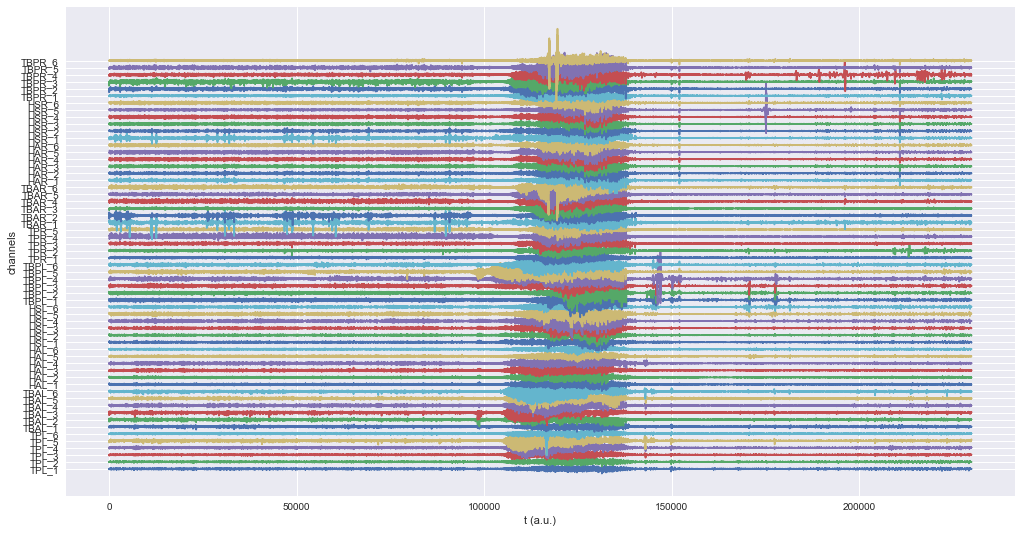

In [4]:
plot_eeg()

For our convenience, we create an interactive plot where we can set the time window and channels we are interested in:

In [5]:
def interactive_plot_eeg(timesteps, channels):
    return plot_eeg(timesteps, channels, sampling_rate=1)

slider_timestep = widgets.IntRangeSlider(
    value=[0, len(df)],
    min=0,
    max=len(df),
    step=10,
    description='Timestep range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
slider_channel = widgets.IntRangeSlider(
    value=[0, len(df.columns)],
    min=0,
    max=len(df.columns),
    step=1,
    description='Channel range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
widgets.interact_manual(
    interactive_plot_eeg,
    timesteps=slider_timestep,
    channels=slider_channel,
    continuous_update=False
)
display()

interactive(children=(IntRangeSlider(value=(0, 229888), continuous_update=False, description='Timestep range:', max=229888, step=10), IntRangeSlider(value=(0, 59), continuous_update=False, description='Channel range:', max=59), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

### EEG sampling rate

After the initial appraisal of the recording, we set ourselves to find its sampling rate. We found that channel *TEL7* is very noisy, more so when compared to its neighbours.

In [6]:
plot_eeg(timesteps=[tt(0),tt(3)], channels=[0, 8], title="artifact")

NameError: name 'tt' is not defined

We plot the power spectral density of TEL7 and then TEL1 for comparison. As we can see, there is a surge in the *TEL7* channel that is not appearing in the case of *TEL1*. To plot the power spectrum density (psd) we need to pass some sampling frequency (which we still don't know), so we employ a placeholder value of 1. We are more interested in the ratios between frequencies at this stage.

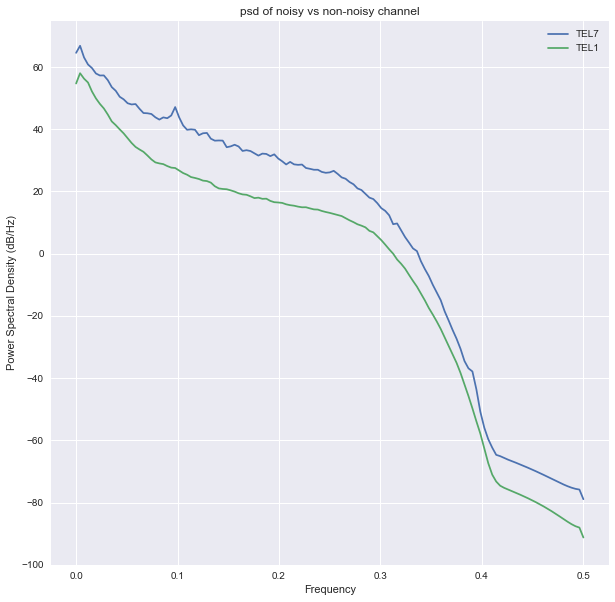

In [77]:
f = plt.figure(figsize=(10, 10))
psd_tel7, *_ = plt.psd(df['TEL7'], NFFT=256, Fs=1)
plt.psd(df['TEL1'], NFFT=256, Fs=1)
plt.legend(['TEL7', 'TEL1'])
plt.title("psd of noisy vs non-noisy channel")
plt.show()

We suspect that the spike around 0.1 in the x-axis in the above plot is caused by the static produced by the AC power line, which has a carrier frequency of 50Hz in the EU. If that is the case, then we can calculate the ratio between the plotted sampling rate and the real one:

In [91]:
print("These are the samples around the spike:")
print(psd_tel7[22:28])
print("And this is the actual spike sample:")
print("index:", 25, "value:", psd_tel7[25])

# Now we calculate exactly what frequency sample 25 would be
freq = 25 / len(psd_tel7) * 0.5
print("Frequency of the spike sample:", freq)

# And if we assume that freq should be 50, by preserving the ratio we can come up with the sampling rate:
sampling_freq = 50 / freq
print("Sampling frequency:", sampling_freq)

These are the samples around the spike:
[ 24097.86661452  22670.05589636  27721.38166472  51743.6418331
  24118.38368772  13326.53590459]
And this is the actual spike sample:
index: 25 value: 51743.6418331
Frequency of the spike sample: 0.09689922480620156
Sampling frequency: 516.0


The sampling frequency was found using the proportion $\frac{0.09689}{1} = \frac{50}{sampling \ rate} \rightarrow sampling \ rate = \frac{50}{0.09689}$ Sampling frequencies are usually powers of 2, so we'll round the value we've obtained (*516Hz*) to the nearest power, which is *512Hz*. Now we replot the power spectrum, this time with the correct sampling rate and we'll see how the axis and the spike are properly aligned:

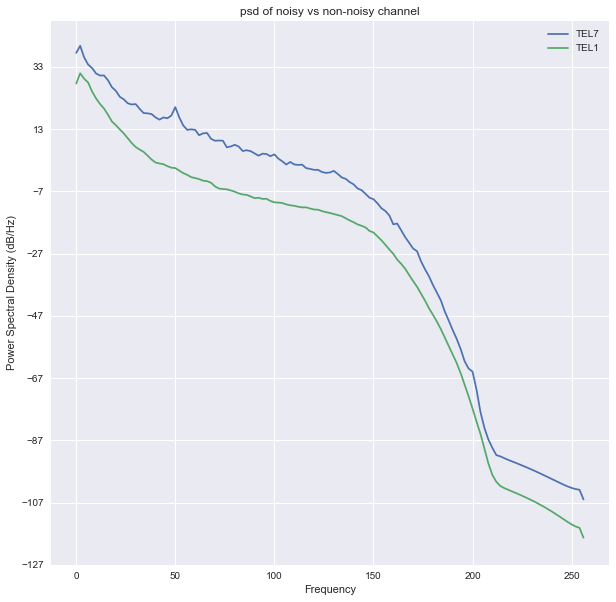

In [94]:
f = plt.figure(figsize=(10, 10))
psd_tel7, *_ = plt.psd(df['TEL7'], NFFT=256, Fs=512)
plt.psd(df['TEL1'], NFFT=256, Fs=512)
plt.legend(['TEL7', 'TEL1'])
plt.title("psd of noisy vs non-noisy channel")
plt.show()

### EEG artifacts

- hello
- what
- IDK
- just yet

In [7]:
def tt(seconds):
    return seconds * 512

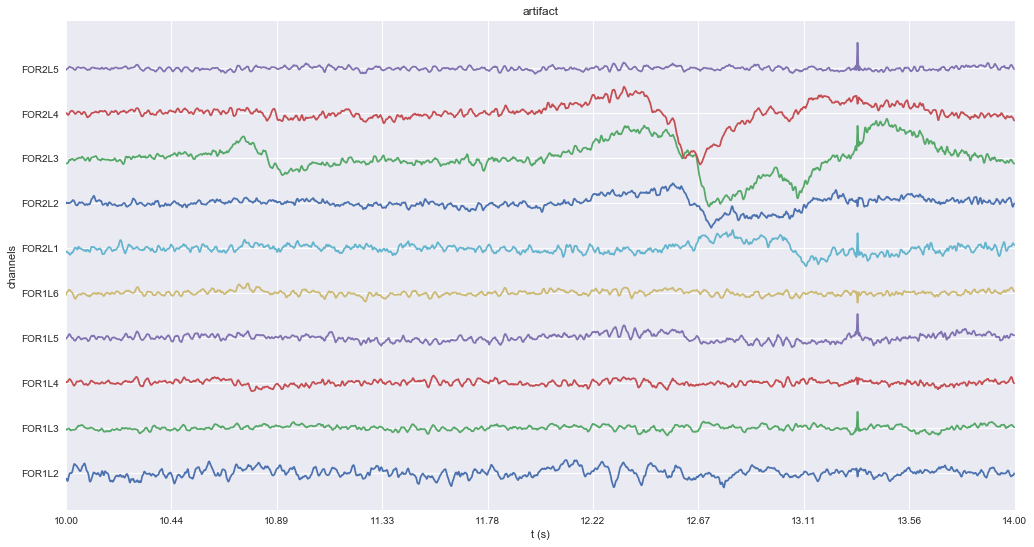

In [97]:
plot_eeg(timesteps=[tt(10),tt(14)], channels=[30, 40], sampling_rate=512, title="artifact")

### EEG features